#Signature Verification model using CNN
##1. Importing Libraries

In [ ]:
import torch
from torch import nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from tqdm.auto import tqdm
import requests
import random
from pathlib import Path
import zipfile
import os
import pickle
from PIL import Image
from timeit import default_timer as timer

In [ ]:
try:
  import torchinfo
  import torchmetrics
except:
  !pip install torchinfo
  !pip install torchmetrics
  from torchinfo import summary
  import torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 14.5 MB/s eta 0:00:00


In [ ]:
# Initializing device variable
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


##1. Getting the Dataset

In [ ]:
# Function to Download and Extract dataset
def download_extract(download_path, download_url):
  with open(download_path / "Dataset.zip", "wb") as f:
    print(f"Downloading the Dataset")
    request = requests.get(download_url)
    f.write(request.content)

  with zipfile.ZipFile(download_path / "Dataset.zip", "r") as zip_file:
    zip_file.extractall(download_path)

  if (download_path / "Dataset.zip").is_file():
    os.remove(download_path / "Dataset.zip")

In [ ]:
data_path = Path("data/")
image_path = data_path / "Signatures/"
english_signatures_path = image_path / "English/"

if image_path.is_dir():
  print(f"Image Directory already exists!")
else:
  print(f"Creating Image Directory")
  image_path.mkdir(parents=True, exist_ok=True)
  english_signatures_path.mkdir(parents=True, exist_ok=True)

download_extract(english_signatures_path, "https://www.dropbox.com/s/9cszpoamsdrq1zn/signatures.zip?dl=1")

Creating Image Directory


##2. Visualizing Dataset

Text(0.5, 0.98, 'Person: 12')

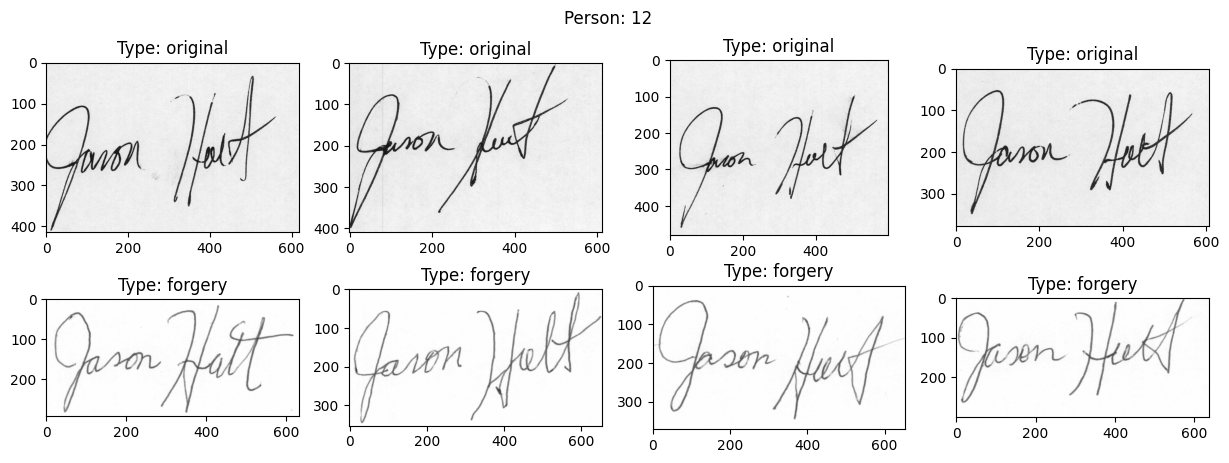

In [ ]:
# Image Paths list
person = 12
original_img_paths = list(Path.glob(english_signatures_path / "original", f"original_{person}_*.png"))
forgery_img_paths = list(Path.glob(english_signatures_path / "forgery", f"forgeries_{person}_*.png"))

fig = plt.figure(figsize=(15, 5))
for i in range(4):
  with Image.open(original_img_paths[i]) as org_img:
    plt.subplot(2, 4, i + 1)
    plt.imshow(org_img, cmap="gray")
    plt.title(f"Type: {original_img_paths[i].parent.stem}")

  with Image.open(forgery_img_paths[i]) as forg_img:
    plt.subplot(2, 4, i + 5)
    plt.imshow(forg_img, cmap="gray")
    plt.title(f"Type: {forgery_img_paths[i].parent.stem}")
fig.suptitle(f"Person: {person}")

torch.Size([1, 96, 192])

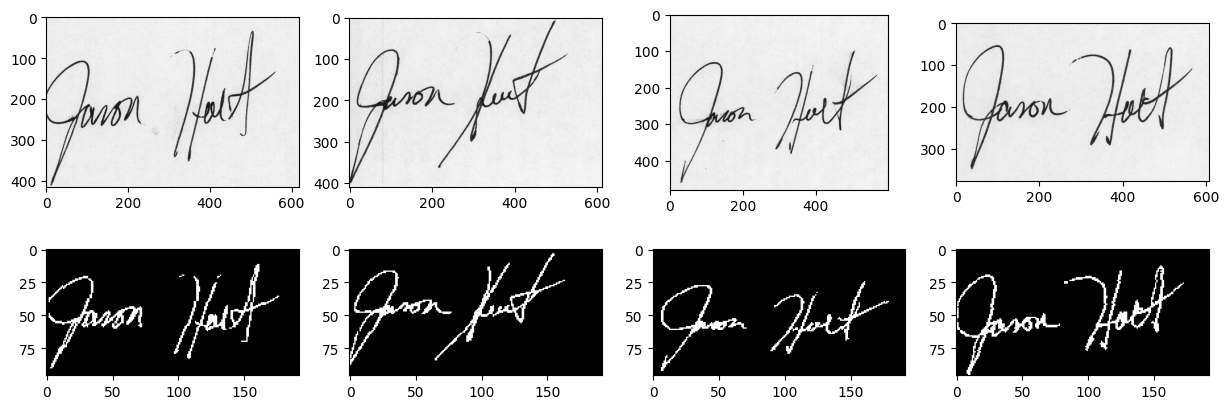

In [ ]:
#Custom Invert Transform
class Invert:
  def __call__(self, image):
    invert_image = transforms.functional.invert(image)
    for i in range(invert_image.shape[1]):
      for j in range(invert_image.shape[2]):
        if (invert_image[0][i][j] <= 0.19607843137):
          invert_image[0][i][j] = 0
        else:
          invert_image[0][i][j] = 1
    return invert_image

# Creating Transform
signature_transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                          transforms.Resize((96, 192)),
                                          transforms.ToTensor(),
                                          Invert(),
                                          transforms.RandomAffine(degrees=(-5, +5),
                                                                  translate=(0.03, 0.05),
                                                                  fill=0)])

# Visualizing Transformed Images
fig = plt.figure(figsize=(15, 5))
for i in range(4):
  with Image.open(original_img_paths[i]) as org_img:
    plt.subplot(2, 4, i + 1)
    plt.imshow(org_img, cmap="gray")

    trans_org_img = signature_transform(org_img)
    plt.subplot(2, 4, i + 5)
    plt.imshow(trans_org_img.squeeze(dim=0), cmap="gray")

trans_org_img.shape

##3. Creating Datasets & DataLoaders

In [ ]:
# Creating Dataset
signature_dataset = datasets.ImageFolder(root=english_signatures_path,
                                         transform=signature_transform,
                                         target_transform=None)

train_dataset, test_dataset = torch.utils.data.random_split(dataset=signature_dataset,
                                                            lengths=(0.75, 0.25))

train_dataset, test_dataset

(<torch.utils.data.dataset.Subset at 0x7f5da5ce0c10>,
 <torch.utils.data.dataset.Subset at 0x7f5da5ce2920>)

In [ ]:
# Cheching the Dataset
print(train_dataset.dataset.class_to_idx)
print(test_dataset.dataset.classes)
print(len(train_dataset), len(test_dataset))

print(signature_dataset.class_to_idx)
print(signature_dataset.classes)
print(len(signature_dataset))

{'forgery': 0, 'original': 1}
['forgery', 'original']
1980 660
{'forgery': 0, 'original': 1}
['forgery', 'original']
2640


In [ ]:
# Creating DataLoaders
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=32,
                              num_workers=os.cpu_count(),
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             pin_memory=True)

##4. Model Implementation

In [ ]:
class SigCNN(nn.Module):
  def __init__(self, input_channels, num_classes):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding="same"),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding="same"),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding="same"),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding="same"),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding="same"),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=9216, out_features=256),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=256, out_features=128),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(in_features=128, out_features=2)
    )

  def forward(self, x):
    return self.classifier(self.features(x))

In [ ]:
# Creating Model object
model_1 = SigCNN(1, 2).to(device)

summary(model_1,
        input_size=(1, 1, 96, 192))

Layer (type:depth-idx)                   Output Shape              Param #
SigCNN                                   [1, 2]                    --
├─Sequential: 1-1                        [1, 512, 3, 6]            --
│    └─Conv2d: 2-1                       [1, 32, 96, 192]          320
│    └─ReLU: 2-2                         [1, 32, 96, 192]          --
│    └─MaxPool2d: 2-3                    [1, 32, 48, 96]           --
│    └─Conv2d: 2-4                       [1, 64, 48, 96]           18,496
│    └─BatchNorm2d: 2-5                  [1, 64, 48, 96]           128
│    └─ReLU: 2-6                         [1, 64, 48, 96]           --
│    └─MaxPool2d: 2-7                    [1, 64, 24, 48]           --
│    └─Conv2d: 2-8                       [1, 128, 24, 48]          73,856
│    └─ReLU: 2-9                         [1, 128, 24, 48]          --
│    └─MaxPool2d: 2-10                   [1, 128, 12, 24]          --
│    └─Conv2d: 2-11                      [1, 256, 12, 24]          295,168


In [ ]:
# Loss fundtion and Optimizer
loss_func = nn.CrossEntropyLoss()

optimizer_1 = torch.optim.Adam(params=model_1.parameters(),
                              lr=0.001)

##5. Training and Testing
###Utility Functions Needed


In [ ]:
def plot_loss_curves(results, dataset_name):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
  ax1.plot(range(len(results["train_loss"])), results["train_loss"], c="g")
  ax1.plot(range(len(results["train_loss"])), results["test_loss"], c="b")
  ax1.set_xlabel ("Epochs")
  ax1.set_ylabel("Loss")
  ax1.set_title(dataset_name)
  ax1.legend(["train_loss", "val_loss"])

  ax2.plot(range(len(results["train_loss"])), results["train_acc"], c="g")
  ax2.plot(range(len(results["train_loss"])), results["test_acc"], c="b")
  ax2.set_xlabel("Epochs")
  ax2.set_ylabel("Accuracy")
  ax2.set_title(dataset_name)
  ax2.legend(["train_acc", "val_acc"])

def save_model(model, target_dir, model_name):
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True, exist_ok=True)

  assert model_name.endswith(".pth") or model_name.endswith(".pt")
  model_save_path = target_dir_path / model_name

  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(), f=model_save_path)

def save_dicts(dict, target_dir, dict_name):
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True, exist_ok=True)

  assert dict_name.endswith(".pkl")
  dict_save_path = target_dir_path / dict_name

  print(f"[INFO] Saving Dictionary to: {dict_save_path}")
  with open(dict_save_path, 'wb') as f:
	  pickle.dump(dict, f, pickle.HIGHEST_PROTOCOL)

def load_model(model_save_path):
  load_model = SigCNN(1, 2)
  load_model.load_state_dict(torch.load(f=Path(model_save_path)))
  load_model = load_model.to(device)
  return load_model

def load_dicts(dicts_save_path):
  with open(dicts_save_path, 'rb') as dict_file:
    temp_dict = pickle.load(dict_file)
  return temp_dict

###Functions to Train and Test model

In [ ]:
def train_step(model, train_dataloader, loss_function, optimizer, device):
  train_loss, train_accuracy = 0, 0

  model.train()

  for batch, (x, y) in enumerate(train_dataloader):
    x, y = x.to(device), y.to(device)

    y_logit = model(x)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    loss = loss_function(y_logit, y)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    train_loss += loss
    train_accuracy += (y_pred == y).sum().item()/len(y_pred)

  train_loss /= len(train_dataloader)
  train_accuracy /= len(train_dataloader)
  return train_loss, train_accuracy

def test_step(model, test_dataloader, loss_function, device):
  test_loss, test_accuracy = 0, 0

  model.eval()
  with torch.inference_mode():
    for batch, (x, y) in enumerate(test_dataloader):
      x, y = x.to(device), y.to(device)

      test_logit = model(x)
      test_pred = torch.softmax(test_logit, dim=1).argmax(dim=1)

      loss = loss_function(test_logit, y)

      test_loss += loss
      test_accuracy += (test_pred == y).sum().item()/len(test_pred)

    test_loss /= len(test_dataloader)
    test_accuracy /= len(test_dataloader)

  return test_loss, test_accuracy

results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

predictions = {
    "preds": [],
    "truth": [],
    "pred_probs": []
}

def train(model, train_dataloader, test_dataloader, loss_func, optimizer, epochs, device):
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_func, optimizer, device)

    test_loss, test_acc = test_step(model, test_dataloader, loss_func, device)

    print(
      f"\nEpoch: {epoch+1} | "
      f"train_loss: {train_loss:.4f} | "
      f"train_acc: {train_acc:.4f} | "
      f"test_loss: {test_loss:.4f} | "
      f"test_acc: {test_acc:.4f}"
    )

    results["train_loss"].append(train_loss.item())
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss.item())
    results["test_acc"].append(test_acc)

In [ ]:
# train(model_1, train_dataloader, test_dataloader, loss_func, optimizer_1, 15, device)

In [ ]:
# save_model(model_1, f"/content/gdrive/My Drive/Results", f"CEDAR_model.pt")
# save_dicts(results, f"/content/gdrive/My Drive/Results", "CEDAR_results.pkl")

##Prediction

In [ ]:
for batch , (x, y) in enumerate(test_dataloader):
  x, y = x.to(device), y.to(device)
  model_1.eval()
  with torch.inference_mode():
    test_logit = model_1(x)
    test_pred = torch.softmax(test_logit, dim=1).argmax(dim=1)
    test_prob = torch.amax(torch.softmax(test_logit, dim=1), dim=1)

    predictions["preds"].append(test_pred)
    predictions["truth"].append(y)
    predictions["pred_probs"].append(test_prob)

preds = torch.cat(predictions["preds"]).to("cpu")
truth = torch.cat(predictions["truth"]).to("cpu")
pred_probs = torch.cat(predictions["pred_probs"]).to("cpu")

In [ ]:
# save_dicts(predictions, f"/content/gdrive/My Drive/Results", "CEDAR_predictions.pkl")

###Loading Model & Dictionaries

In [ ]:
load_model = load_model(f"/content/gdrive/My Drive/CEDAR2/CEDAR_model.pt")
results = load_dicts(f"/content/gdrive/My Drive/CEDAR2/CEDAR_results.pkl")
predictions = load_dicts(f"/content/gdrive/My Drive/CEDAR2/CEDAR_predictions.pkl")

preds = torch.cat(predictions["preds"]).to("cpu")
truth = torch.cat(predictions["truth"]).to("cpu")
pred_probs = torch.cat(predictions["pred_probs"]).to("cpu")

##Confusion Matrix

In [ ]:
import seaborn as sns
with open("cf_matrix.py", 'wb') as f:
  request = requests.get("https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py")
  f.write(request.content)

from cf_matrix import make_confusion_matrix
sns.set_context('talk')

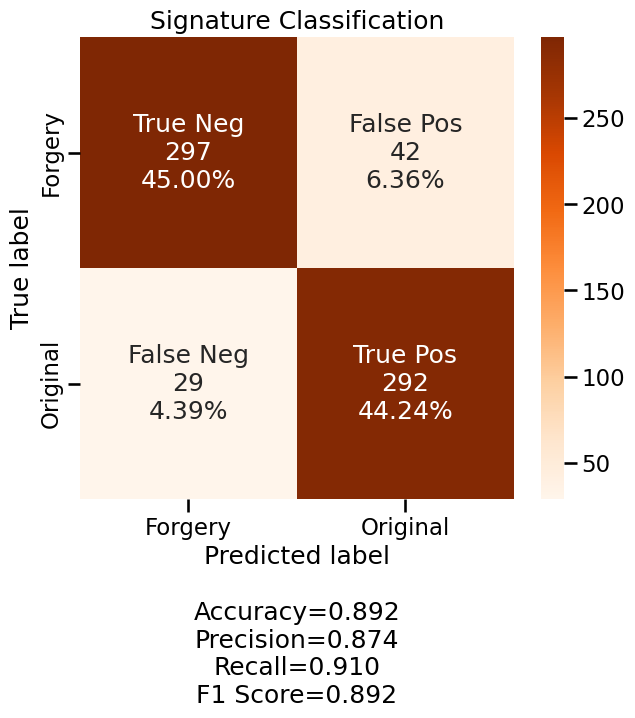

In [ ]:
confusion_matrix = torchmetrics.ConfusionMatrix(task="binary", num_classes=2)

confusion_mat = confusion_matrix(preds, truth)

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Forgery', 'Original']
make_confusion_matrix(cf=confusion_mat.numpy(),
                      figsize=(7, 6),
                      cbar=True,
                      title='Signature Classification',
                      cmap='Oranges',
                      categories=categories,
                      group_names=labels)